In [1]:
plt = plotter()
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [2]:
import jax
import jax.numpy as np
import numpy as np0

In [3]:
import valjax as vj
import valjax.tools as vt

## Optimize

In [5]:
spec = vt.Spec('log')

In [39]:
def f(x, α):
    return np.log(x) - x/α
def fx(y, α):
    x = spec.decode(y)
    return f(x, α)
dfx = jax.grad(fx)
ddfx = jax.grad(dfx)

In [40]:
def opt(α, x0, clip=2.0, K=5):
    dobj1 = jax.partial(dfx, α=α)
    ddobj1 = jax.partial(ddfx, α=α)
    y0 = spec.encode(x0)
    y1 = vj.optim_newton(dobj1, ddobj1, y0, clip=clip, K=K)
    x1 = spec.decode(y1)
    return x1
dopt = jax.grad(opt)

In [41]:
opt(1.5, 0.5) # = α

DeviceArray(1.5000005, dtype=float32)

In [42]:
dopt(1.5, 0.5) # = 1

DeviceArray(1.000012, dtype=float32)

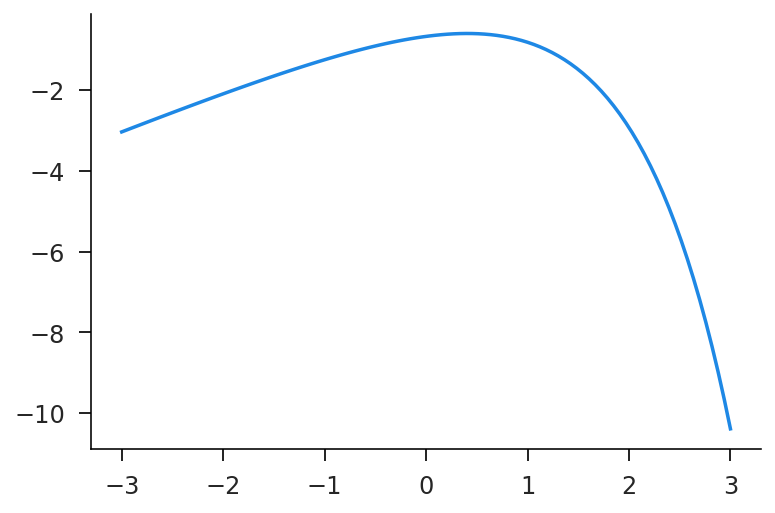

In [49]:
y = np.linspace(-3.0, 3.0, 100)
plt.plot(y, fx(y, 1.5));

In [97]:
slv0 = vj.optimer_diff(fx, -5.0, 5.0)
slv = lambda α: spec.decode(slv0(α))
dslv = jax.value_and_grad(slv)
jdslv = jax.jit(dslv)

In [99]:
%time jdslv(1.5)

CPU times: user 836 µs, sys: 0 ns, total: 836 µs
Wall time: 376 µs


(DeviceArray(1.4999999, dtype=float32), DeviceArray(0.99999994, dtype=float32))

## Interpolation

In [11]:
x = np.linspace(0, 1, 101)
y = x*(1-x)

In [12]:
def dummy_interp(x1):
    return vj.interp(x, y, x1)
d_dummy_interp = jax.grad(dummy_interp)
dv_dummy_interp = jax.vmap(d_dummy_interp)

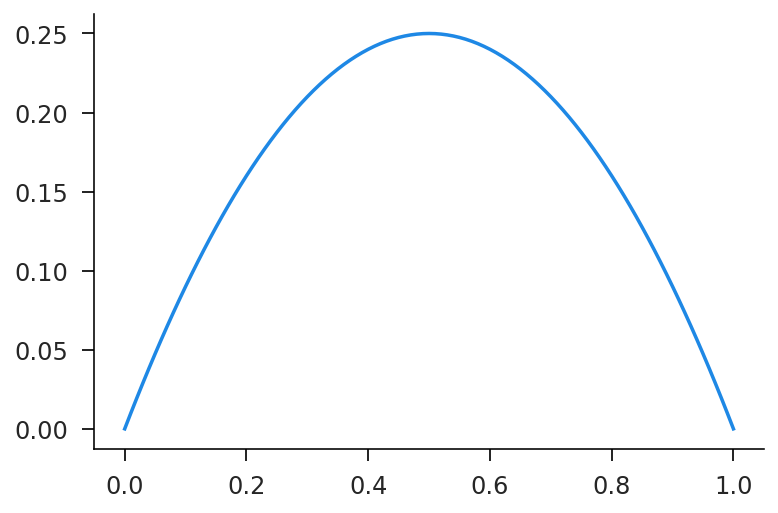

In [13]:
y1 = dummy_interp(x)
plt.plot(x, y1);

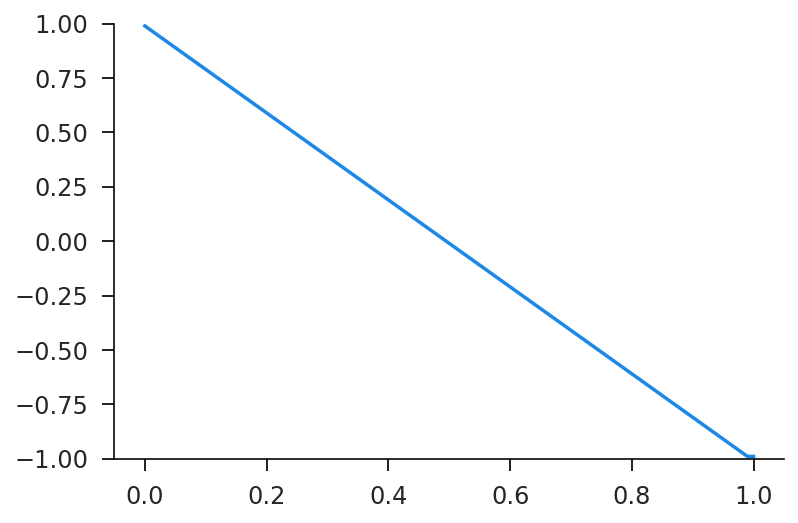

In [14]:
dy1 = dv_dummy_interp(x)
plt.plot(x, dy1);
plt.ylim(-1, 1);

## Grid Optimize

In [15]:
N = 10000
s_grid = np.linspace(0, 1, N)

In [16]:
def obj(s, c):
    return -(s-c)**2

In [17]:
def tot(c):
    return np.sum(obj(s_grid, c))

In [18]:
dtot = jax.grad(tot)

In [19]:
jtot = jax.jit(tot)
jdtot = jax.jit(dtot)

In [20]:
K = 250
speed = 0.01

In [21]:
c = 0.5*np.ones(N)
hist = np0.zeros(K)
for i in range(K):
    hist[i] = jtot(c)
    dc = jdtot(c)
    c += speed*dc

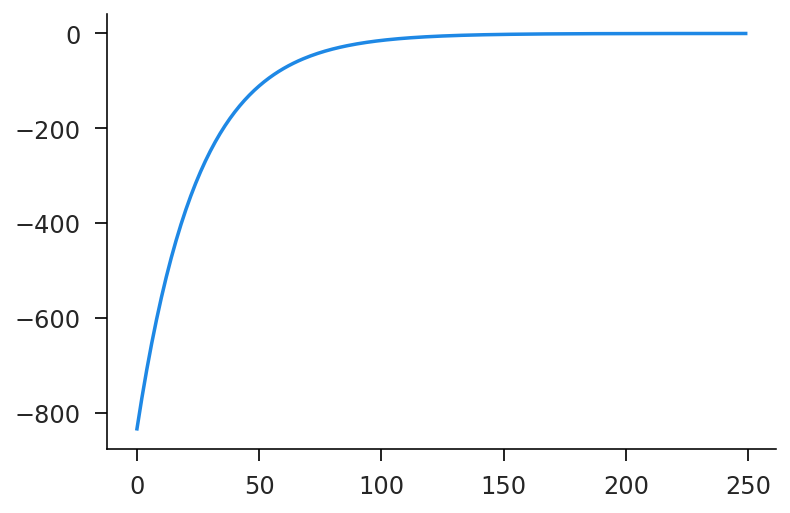

In [22]:
plt.plot(hist);

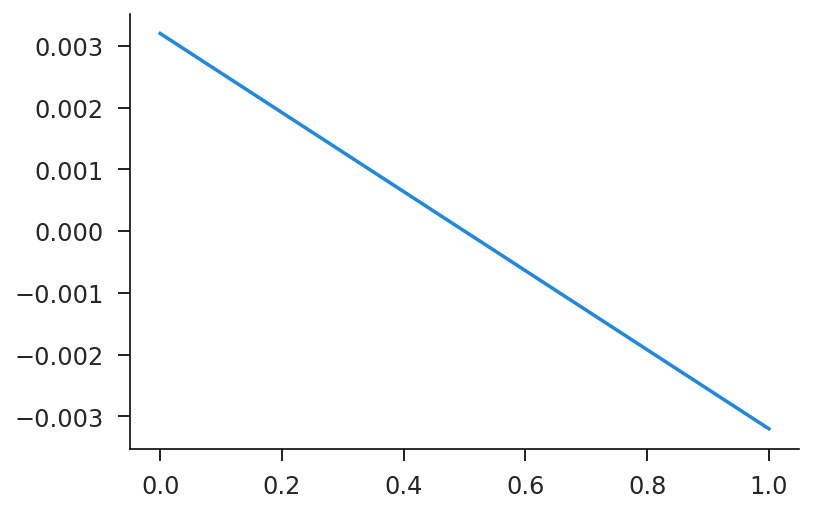

In [23]:
plt.plot(s_grid, c - s_grid);

### Smoothmax Optimize

Need to make interp 2x differentiable! Spline time?

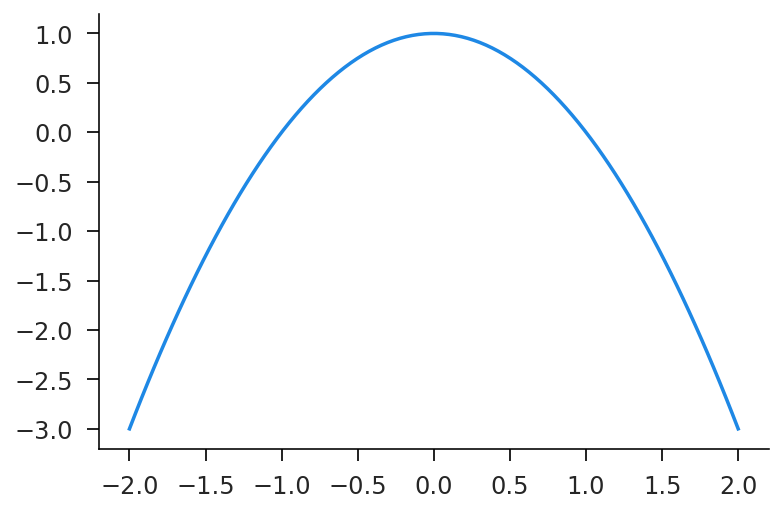

In [101]:
x = np.linspace(-2, 2, 100)
y = 1 - x**2
plt.plot(x, y);

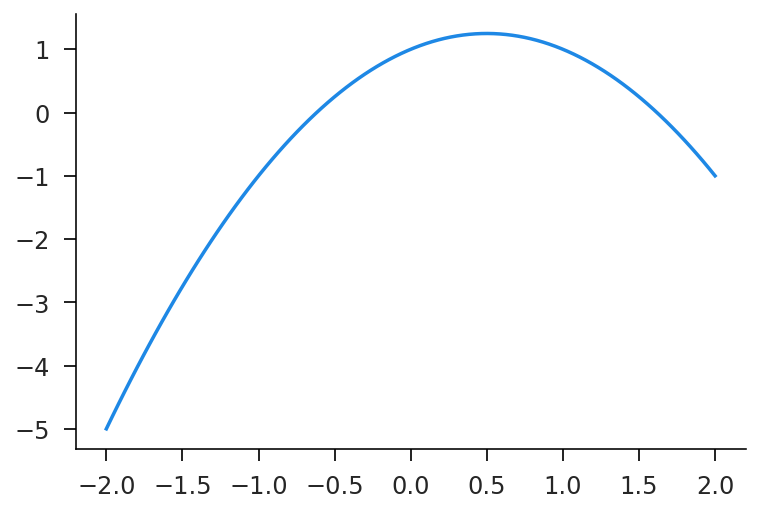

In [119]:
def obj(c, α):
    return α*c + vj.interp(x, y, c)
plt.plot(x, obj(x, 1.));

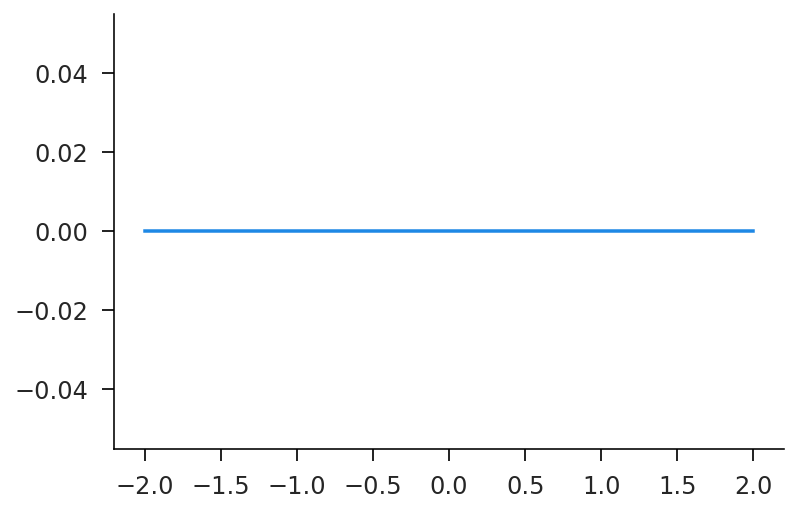

In [138]:
dobj = jax.grad(obj)
ddobj = jax.grad(dobj)
vddobj = jax.vmap(ddobj, in_axes=(0, None))
plt.plot(x, vddobj(x, 1.));

In [136]:
opt = vj.solver_diff(dobj, -2., 2.)

In [137]:
opt(1.)

DeviceArray(inf, dtype=float32)

In [144]:
def obj0(x, α):
    return α*x - 0.5*x**2
opt = vj.optimer_diff(obj0, -2., 2.)
vopt = jax.vmap(opt)
vopt(np.linspace(0, 1, 10))

DeviceArray([0.        , 0.11111111, 0.22222222, 0.33333334, 0.44444445,
             0.5555556 , 0.6666667 , 0.7777778 , 0.8888889 , 1.        ],            dtype=float32)